In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)
TIME_STEP = 10
INPUT_SIZE = 1
LR = 0.02
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE = 'cpu'

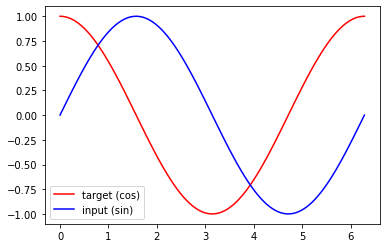

In [2]:
steps = torch.linspace(0, 2*np.pi, 100)
x_torch = torch.sin(steps)
y_torch = torch.cos(steps)
plt.plot(steps, y_torch, 'r-', label='target (cos)')
plt.plot(steps, x_torch, 'b-', label='input (sin)')
plt.legend(loc='best')
plt.show()

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=32,
            num_layers=1,
            batch_first=True
        )
        self.fc = nn.Linear(32, 1)
    
    def forward(self, x, h_state):
        r_out, h_state = self.rnn(x, h_state)
        out = []
        for time_step in range(r_out.size(1)):
            out.append(self.fc(r_out[:, time_step, :]))
        return torch.stack(out, dim=1), h_state      # list -> tensor

In [4]:
net = Net()
print(net)
net.to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LR)

Net(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


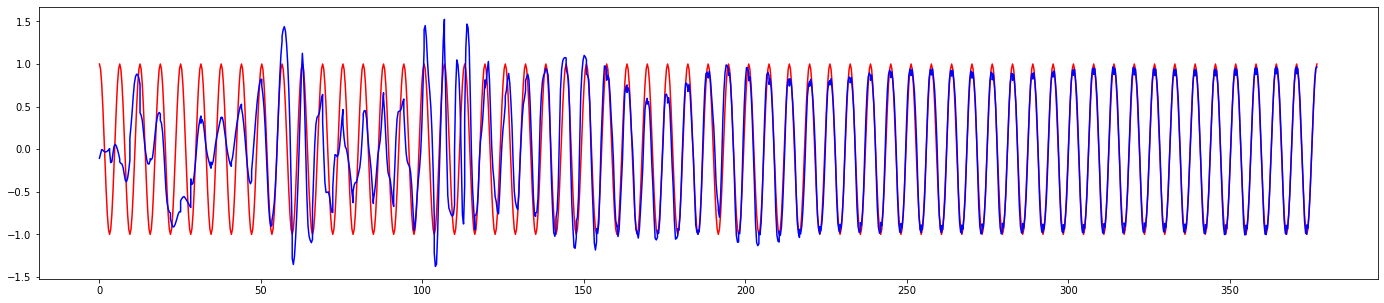

In [5]:
x_all = torch.tensor([])
y1_all = torch.tensor([])
y2_all = torch.tensor([])

h_state = None
for t in range(120):
    start, end = t * np.pi, (t+1) * np.pi
    steps = torch.linspace(start, end, TIME_STEP)
    inputs = torch.sin(steps).view(1, -1, 1).to(DEVICE)
    targets = torch.cos(steps).view(1, -1, 1).to(DEVICE)
    
    net.zero_grad()
    outputs, h_state = net(inputs, h_state)
    # print(type(h_state))
    h_state = h_state.data
    
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    
    # print(targets.cpu().detach().flatten().size())
    # print(outputs.cpu().detach().flatten().size())
    x_all = torch.cat((x_all, steps), dim=0)
    y1_all = torch.cat((y1_all, targets.cpu().detach().flatten()), dim=0)
    y2_all = torch.cat((y2_all, outputs.cpu().detach().flatten()), dim=0)
    
plt.figure(1, figsize=(24, 5))
plt.plot(x_all, y1_all, 'r-')
plt.plot(x_all, y2_all, 'b-')
plt.draw();